## Part 1


In [1]:
# imports
import wordcloud
from wordcloud import WordCloud
import json
from collections import defaultdict
from array import array
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# load data
import json, gzip
from pathlib import Path

def iter_json_objects(path):
    opener = gzip.open if str(path).endswith('.gz') else open
    with opener(path, 'rt', encoding='utf-8') as f:
        first = f.read(1)
        f.seek(0)
        if first == '[':
            try:
                import ijson
                for obj in ijson.items(f, 'item'):
                    yield obj
            except ImportError:
                data = json.load(f)
                for obj in data:
                    yield obj
        else:
            for line in f:
                line = line.strip()
                if line:
                    yield json.loads(line)

NOTEBOOK_DIR = Path().resolve()
DATA_PATH = NOTEBOOK_DIR.parents[1] / "data" / "fashion_products_dataset.json"

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Dataset not found at {DATA_PATH}. "
        "Please make sure 'fashion_products_dataset.json' is placed in the 'data/' folder at the repo root."
    )

print("Dataset path:", DATA_PATH)

records = list(iter_json_objects(DATA_PATH))
print(f"Loaded {len(records)} records successfully")

Dataset path: C:\Users\alber\Documents\GitHub\irwa-search-engine-g_019\data\fashion_products_dataset.json
Loaded 28080 records successfully


In [3]:
# prep
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def to_number(x):
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    s = str(x).replace(",", "").strip().lower()
    if "% off" in s:
        s = s.split("%")[0]
    if s in ["true", "false"]:
        return 1.0 if s == "true" else 0.0
    try:
        return float(s)
    except ValueError:
        return np.nan

def details_to_text(details):
    if not details:
        return ""
    out = []
    for d in details:
        if isinstance(d, dict):
            for key, val in d.items():
                out.append(f"{key} {val}")
    return " ".join(out)

def process_product(prod):
    title = prod.get("title", "")
    desc = prod.get("description", "")
    dets = details_to_text(prod.get("product_details"))
    full_text = f"{title} {desc} {dets}"
    tokens = word_tokenize(full_text)
    tokens = [t.lower() for t in tokens if t.isalnum()]
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and len(t) > 2]
    clean_text = " ".join(tokens)
    return {
        "pid": prod.get("pid", ""),
        "title": title,
        "description": desc,
        "brand": prod.get("brand", ""),
        "category": prod.get("category", ""),
        "sub_category": prod.get("sub_category", ""),
        "product_details": prod.get("product_details", []),
        "seller": prod.get("seller", ""),
        "out_of_stock": to_number(prod.get("out_of_stock")),
        "selling_price": to_number(prod.get("selling_price")),
        "discount": to_number(prod.get("discount")),
        "actual_price": to_number(prod.get("actual_price")),
        "average_rating": to_number(prod.get("average_rating")),
        "url": prod.get("url", ""),
        "tokens": clean_text
    }

In [4]:
# process data
processed_data = [process_product(rec) for rec in iter_json_objects(DATA_PATH)]
products_df = pd.DataFrame(processed_data)
products_df.set_index("pid", inplace=True)
products_df.head(4)

,title,description,brand,category,sub_category,product_details,seller,out_of_stock,selling_price,discount,actual_price,average_rating,url,tokens
pid,,,,,,,,,,,,,,
TKPFCZ9EA7H5FYZH,Solid Women Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO2'}, {'Closure': 'El...",Shyam Enterprises,0.0,921.0,69.0,2999.0,3.9,https://www.flipkart.com/yorker-solid-men-mult...,solid women multicolor track pant yorker track...
TKPFCZ9EJZV2UVRZ,Solid Men Blue Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005BLUE'}, {'Closure': 'Draw...",Shyam Enterprises,0.0,499.0,66.0,1499.0,3.9,https://www.flipkart.com/yorker-solid-men-blue...,solid men blue track pant yorker trackpant mad...
TKPFCZ9EHFCY5Z4Y,Solid Men Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO4'}, {'Closure': 'El...",Shyam Enterprises,0.0,931.0,68.0,2999.0,3.9,https://www.flipkart.com/yorker-solid-men-mult...,solid men multicolor track pant yorker trackpa...
TKPFCZ9ESZZ7YWEF,Solid Women Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO3'}, {'Closure': 'El...",Shyam Enterprises,0.0,911.0,69.0,2999.0,3.9,https://www.flipkart.com/yorker-solid-men-mult...,solid women multicolor track pant yorker track...


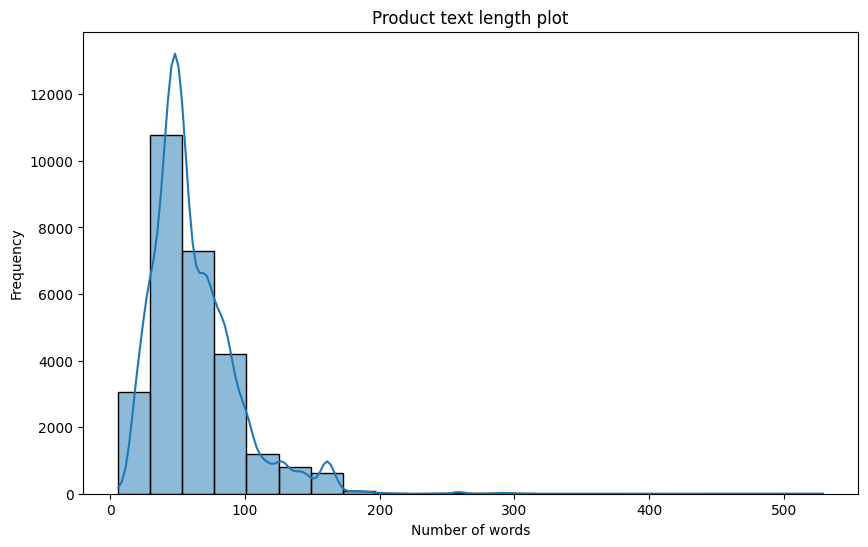

In [5]:
# plot text length
vocab_df = products_df.copy()
vocab_df['Wordcount'] = products_df['tokens'].fillna('').apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.histplot(vocab_df['Wordcount'], bins=22, kde=True)
plt.title('Product text length plot')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

In [6]:
# vocab info
whole_content = products_df['tokens'].fillna('').str.split().explode().tolist()
word_counts = Counter(whole_content)
vocab_dict = dict(word_counts)
print('Product vocabulary size is', len(vocab_dict))
sorted_dict = sorted(vocab_dict.items(), key=lambda x: x[1], reverse=True)
print('\nThe top 5 most appearing words are:')
for item in sorted_dict[:5]:
    print(item)

Product vocabulary size is 15877

The top 5 most appearing words are:
('fabric', 57213)
('neck', 56553)
('sleev', 50876)
('fit', 39523)
('type', 38701)


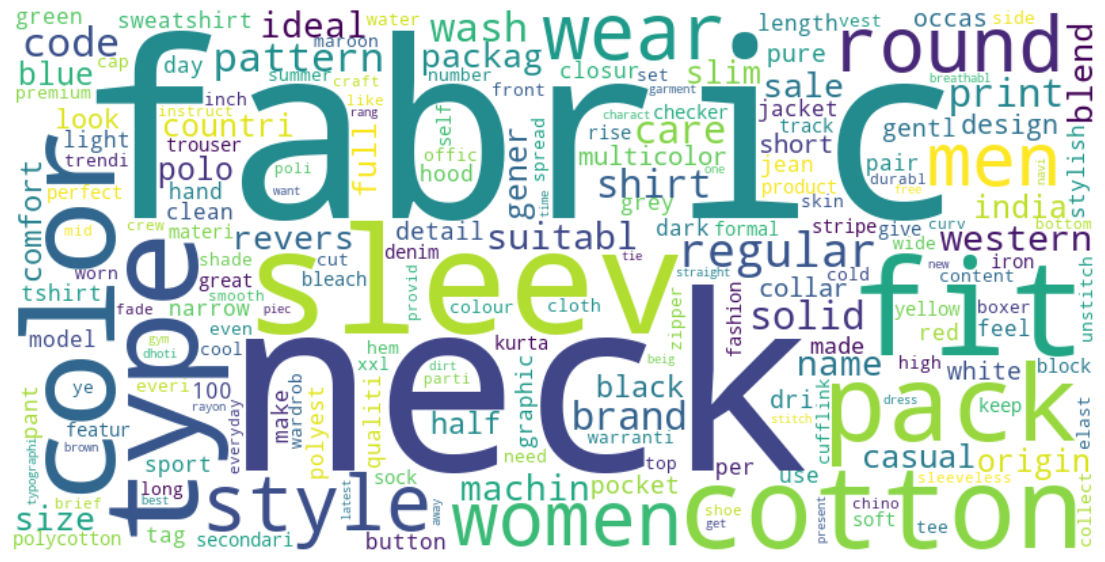

In [7]:
# word cloud
words_wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(vocab_dict)
plt.figure(figsize=(14,8))
plt.imshow(words_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
# top rated products
rated_df = products_df.copy()
rated_sorted = rated_df.sort_values(by='average_rating', ascending=False)
print('The following are the Top 5 Highest-Rated Products:')
rated_sorted.reset_index().drop(columns=['pid','url'], errors='ignore').head(5)

The following are the Top 5 Highest-Rated Products:


,title,description,brand,category,sub_category,product_details,seller,out_of_stock,selling_price,discount,actual_price,average_rating,tokens
0,Men Brief (Pack of 5),Regular use & fit,COL,Clothing and Accessories,Innerwear and Swimwear,"[{'Color': 'Multicolor'}, {'Fabric': 'Cotton J...",SkipperInd,0.0,385.0,50.0,770.0,5.0,men brief pack regular use fit color multicolo...
1,VIP Women Vest (Pack of 8),All day comfort and support from work to play ...,,Clothing and Accessories,Innerwear and Swimwear,"[{'Neck': 'Round Neck'}, {'Pattern': 'Solid'},...",,1.0,1108.0,7.0,1196.0,5.0,vip women vest pack day comfort support work p...
2,Graphic Print Women Round Neck White T-Shirt,,TEE BUD,Clothing and Accessories,Topwear,"[{'Type': 'Round Neck'}, {'Sleeve': 'Short Sle...",T-SHIRT EXPRESS,0.0,349.0,61.0,899.0,5.0,graphic print women round neck white type roun...
3,Men Brief (Pack of 5),100 cm,VIKING.INE,Clothing and Accessories,Innerwear and Swimwear,"[{'Color': 'Multicolor'}, {'Fabric': 'Cotton B...",,1.0,699.0,NaN,NaN,5.0,men brief pack 100 color multicolor fabric cot...
4,Men Slim Fit Printed Spread Collar Casual Shirt,,True Bl,Clothing and Accessories,Topwear,"[{'Pack of': '1'}, {'Style Code': '20319816-Be...",KAPSONSRETAILPVTLTD,0.0,1119.0,60.0,2799.0,5.0,men slim fit print spread collar casual shirt ...


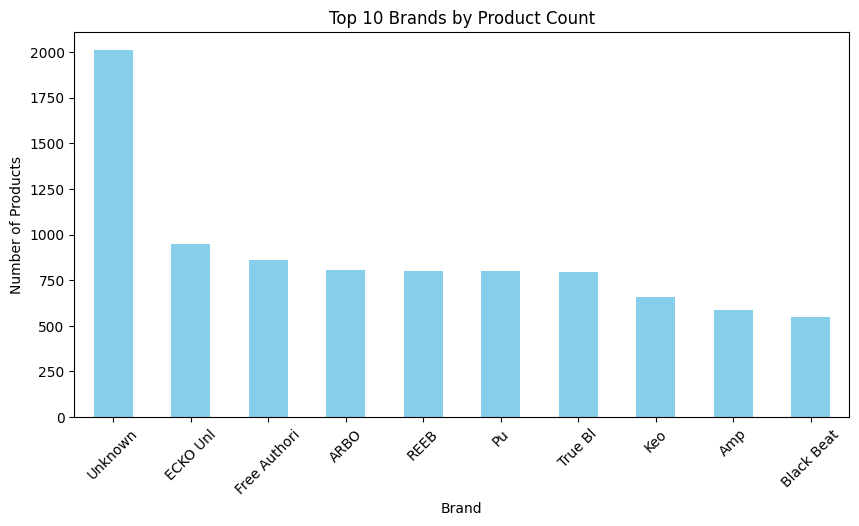

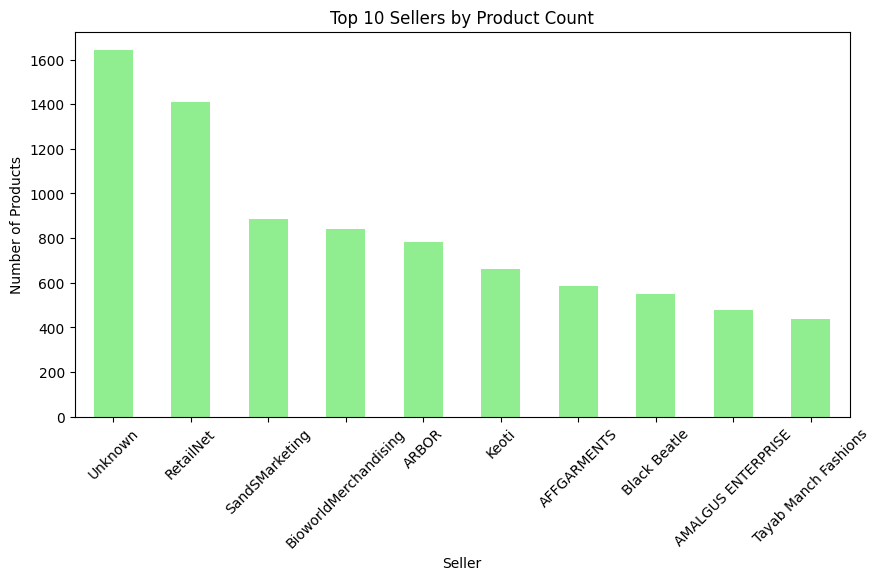

In [9]:
# brands and sellers
products_df['brand'] = products_df['brand'].fillna('Unknown')
products_df['brand'] = products_df['brand'].replace('', 'Unknown')
top_brands = products_df['brand'].value_counts().head(10)
plt.figure(figsize=(10,5))
top_brands.plot(kind='bar', color='skyblue')
plt.title('Top 10 Brands by Product Count')
plt.xlabel('Brand')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.show()
products_df['seller'] = products_df['seller'].fillna('Unknown')
products_df['seller'] = products_df['seller'].replace('', 'Unknown')
top_sellers = products_df['seller'].value_counts().head(10)
plt.figure(figsize=(10,5))
top_sellers.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Sellers by Product Count')
plt.xlabel('Seller')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.show()

## Part 2 — Indexing & Evaluation

In [ ]:
# search engine
TEXT_COL = "tokens_plus" if "tokens_plus" in products_df.columns else "tokens"
from collections import defaultdict, Counter
import math

docs = products_df[TEXT_COL].fillna("")
doc_ids = products_df.index.astype(str).tolist()
vocab = {}
postings = defaultdict(list)
df = Counter()
for pid, text in zip(doc_ids, docs):
    terms = text.split()
    if not terms:
        continue
    tf = Counter(terms)
    for t, f in tf.items():
        if t not in vocab:
            vocab[t] = len(vocab)
        df[t] += 1
        postings[t].append((pid, f))
N = len(doc_ids)
idf = {t: math.log((N + 1) / (df[t] + 1)) + 1.0 for t in df}
doc_norm = defaultdict(float)
for t, plist in postings.items():
    w_idf = idf[t]
    for pid, f in plist:
        w = (1 + math.log(f)) * w_idf
        doc_norm[pid] += w * w
for pid in list(doc_norm.keys()):
    doc_norm[pid] = math.sqrt(doc_norm[pid])
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
def preprocess_query(q):
    toks = word_tokenize(q)
    toks = [t.lower() for t in toks if t.isalnum()]
    toks = [stemmer.stem(t) for t in toks if t not in stop_words and len(t) > 2]
    return toks
def search_and_rank(query, top_k=20):
    q_terms = preprocess_query(query)
    if not q_terms:
        return []
    term_lists = []
    for t in q_terms:
        if t not in postings:
            return []
        term_lists.append(set(pid for pid, _ in postings[t]))
    cand = set.intersection(*term_lists) if term_lists else set()
    if not cand:
        return []
    q_tf = Counter(q_terms)
    q_weights = {}
    q_norm = 0.0
    for t, f in q_tf.items():
        w = (1 + math.log(f)) * idf.get(t, 0.0)
        q_weights[t] = w
        q_norm += w*w
    q_norm = math.sqrt(q_norm) if q_norm > 0 else 1.0
    scores = defaultdict(float)
    for t, wq in q_weights.items():
        for pid, f in postings.get(t, []):
            if pid not in cand:
                continue
            wd = (1 + math.log(f)) * idf.get(t, 0.0)
            scores[pid] += wq * wd
    ranked = []
    for pid, s in scores.items():
        dnorm = doc_norm.get(pid, 1.0)
        ranked.append((pid, s / (dnorm * q_norm if dnorm else 1.0)))
    ranked.sort(key=lambda x: x[1], reverse=True)
    out = products_df.loc[[pid for pid, _ in ranked[:top_k]], ["title","brand","category","url"]].copy()
    out.insert(0, "pid", [pid for pid,_ in ranked[:top_k]])
    out["score"] = [score for _, score in ranked[:top_k]]
    return out
# test
display(search_and_rank("women full sleeve sweatshirt cotton", top_k=10))

,pid,title,brand,category,url,score
pid,,,,,,
SWSF9W4TCKGPSSZZ,SWSF9W4TCKGPSSZZ,Full Sleeve Printed Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-pr...,0.631933
SWSFYTYMNTBNARUN,SWSFYTYMNTBNARUN,Full Sleeve Solid Women Sweatshirt,ARBO,Clothing and Accessories,https://www.flipkart.com/arbour-full-sleeve-so...,0.627816
SWSFYFFFJZN6P6ZW,SWSFYFFFJZN6P6ZW,Full Sleeve Printed Women Sweatshirt,MASH UNLIMIT,Clothing and Accessories,https://www.flipkart.com/mash-unlimited-full-s...,0.622971
SWSF9W3ZHHJFQFJF,SWSF9W3ZHHJFQFJF,Full Sleeve Printed Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-pr...,0.610852
SWSFZAUYZFAGEPKK,SWSFZAUYZFAGEPKK,Full Sleeve Printed Women Sweatshirt,BLACK SN,Clothing and Accessories,https://www.flipkart.com/black-snow-full-sleev...,0.602448
SWSFVZRFS7GHGKSF,SWSFVZRFS7GHGKSF,Full Sleeve Solid Women Sweatshirt,RELIEF ZO,Clothing and Accessories,https://www.flipkart.com/relief-zone-full-slee...,0.601032
SWSF9W4TBFMF3GZA,SWSF9W4TBFMF3GZA,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-st...,0.600254
SWSF9W4HABG6BBY4,SWSF9W4HABG6BBY4,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-st...,0.594443
SWSF9W4TTB2M9ZXT,SWSF9W4TTB2M9ZXT,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-st...,0.591259


In [11]:
# frequent tokens
from collections import Counter
from random import sample
top_terms = Counter(" ".join(products_df[TEXT_COL].fillna("")).split()).most_common(200)
filtered = [t for t,_ in top_terms if t not in stop_words and len(t) > 3 and t not in {"size","color"}]
print(filtered[:20])

['fabric', 'neck', 'sleev', 'type', 'cotton', 'pack', 'style', 'wear', 'round', 'women', 'regular', 'pattern', 'wash', 'code', 'care', 'print', 'shirt', 'solid', 'brand', 'suitabl']


In [12]:
# test queries
test_queries = [
    "women cotton shirt",
    "round neck shirt",
    "solid pattern wear",
    "men regular fit",
    "printed cotton fabric"
]
test_queries

['women cotton shirt',
 'round neck shirt',
 'solid pattern wear',
 'men regular fit',
 'printed cotton fabric']

In [13]:
# run queries
for q in test_queries:
    print(f"\nQuery: {q}")
    display(search_and_rank(q, top_k=5))


Query: women cotton shirt


,pid,title,brand,category,url,score
pid,,,,,,
SHTFTK76BEPJKDZ7,SHTFTK76BEPJKDZ7,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-solid-casu...,0.437528
SHTFTJW9BUDMGUGV,SHTFTJW9BUDMGUGV,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.426968
SHTFTJWAV7JGQHCB,SHTFTJWAV7JGQHCB,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.426968
SHTFTJWB5PUSRMAC,SHTFTJWB5PUSRMAC,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.426968
SHTFTJW9N7HR4Z5R,SHTFTJW9N7HR4Z5R,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.426968



Query: round neck shirt


,pid,title,brand,category,url,score
pid,,,,,,
TSHFW9CRK3GZDAGX,TSHFW9CRK3GZDAGX,Printed Men Round Neck Black T-Shirt,Rose We,Clothing and Accessories,https://www.flipkart.com/rose-wear-printed-men...,0.498467
TSHFW9CRBTZTKCGN,TSHFW9CRBTZTKCGN,Printed Men Round Neck White T-Shirt,Rose We,Clothing and Accessories,https://www.flipkart.com/rose-wear-printed-men...,0.489446
TSHFWZYBQPYSREDB,TSHFWZYBQPYSREDB,Solid Women Round Neck White T-Shirt,CA,Clothing and Accessories,https://www.flipkart.com/cara-solid-men-round-...,0.485436
TSHFW9CRFQCQCH4Q,TSHFW9CRFQCQCH4Q,Printed Women Round Neck Grey T-Shirt,Rose We,Clothing and Accessories,https://www.flipkart.com/rose-wear-printed-men...,0.484208
TSHEZP37J8S3SREJ,TSHEZP37J8S3SREJ,Solid Men Round Neck Black T-Shirt,HUMBE,Clothing and Accessories,https://www.flipkart.com/humbert-solid-men-rou...,0.478578



Query: solid pattern wear


,pid,title,brand,category,url,score
pid,,,,,,
SHTFTJZ4XKAVFCNH,SHTFTJZ4XKAVFCNH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-solid-casu...,0.349782
SHTFTJZ4GZZYTFYN,SHTFTJZ4GZZYTFYN,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-solid-casu...,0.349782
SHTFTJZ4RETDZMQH,SHTFTJZ4RETDZMQH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-solid-casu...,0.347964
SHTFZSP23MASGF2Z,SHTFZSP23MASGF2Z,Women Regular Fit Solid Formal Shirt,PROLI,Clothing and Accessories,https://www.flipkart.com/prolife-men-solid-for...,0.344774
SHTFTJZ4AARXMGJ8,SHTFTJZ4AARXMGJ8,Men Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-solid-casu...,0.343878



Query: men regular fit


,pid,title,brand,category,url,score
pid,,,,,,
TSHFN6QANCZHVQZB,TSHFN6QANCZHVQZB,Solid Men Round Neck Blue T-Shirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-solid-men-roun...,0.422367
TSHF2DZ6YS662GFQ,TSHF2DZ6YS662GFQ,Solid Men V-neck White T-Shirt,rockha,Clothing and Accessories,https://www.flipkart.com/rockhard-solid-men-v-...,0.419115
SHTFNFWCK6AK9J7G,SHTFNFWCK6AK9J7G,Men Regular Fit Printed Casual Shirt,allan pet,Clothing and Accessories,https://www.flipkart.com/allan-peter-men-print...,0.411593
SHTFNFTFZBYNCT5E,SHTFNFTFZBYNCT5E,Men Regular Fit Printed Casual Shirt,allan pet,Clothing and Accessories,https://www.flipkart.com/allan-peter-men-print...,0.411593
TSHFN6QA9RZDMFGS,TSHFN6QA9RZDMFGS,Solid Men Round Neck Blue T-Shirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-solid-men-roun...,0.410053



Query: printed cotton fabric


,pid,title,brand,category,url,score
pid,,,,,,
SHTFTJW9BUDMGUGV,SHTFTJW9BUDMGUGV,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.427697
SHTFTJWAV7JGQHCB,SHTFTJWAV7JGQHCB,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.427697
SHTFTJWB5PUSRMAC,SHTFTJWB5PUSRMAC,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.427697
SHTFTJW9N7HR4Z5R,SHTFTJW9N7HR4Z5R,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.427697
SHTFTJWCPVTWGBYW,SHTFTJWCPVTWGBYW,Men Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.427559


In [14]:
# metrics
def precision_at_k(y_true, y_pred, k=10):
    pred = y_pred[:k]
    hits = sum(y_true.get(pid, 0) for pid in pred)
    return hits / float(k)
def recall_at_k(y_true, y_pred, k=10):
    pred = y_pred[:k]
    rel_total = sum(y_true.values())
    hits = sum(y_true.get(pid, 0) for pid in pred)
    return hits / max(1, rel_total)
def ap_at_k(y_true, y_pred, k=10):
    ap, hits = 0.0, 0
    for i, pid in enumerate(y_pred[:k], start=1):
        if y_true.get(pid, 0):
            hits += 1
            ap += hits / i
    rel_total = sum(y_true.values())
    return ap / max(1, min(rel_total, k))
def f1_at_k(y_true, y_pred, k=10):
    p = precision_at_k(y_true, y_pred, k)
    r = recall_at_k(y_true, y_pred, k)
    return 2*p*r / (p + r) if (p+r) > 0 else 0.0
def map_score(list_of_labeldicts, list_of_rankings, k=10):
    aps = [ap_at_k(y_true, y_pred, k) for y_true, y_pred in zip(list_of_labeldicts, list_of_rankings)]
    return float(np.mean(aps)) if aps else 0.0
def mrr(list_of_labeldicts, list_of_rankings, k=10):
    rr = []
    for y_true, y_pred in zip(list_of_labeldicts, list_of_rankings):
        rank = None
        for i, pid in enumerate(y_pred[:k], start=1):
            if y_true.get(pid, 0):
                rank = i; break
        rr.append(1.0/rank if rank else 0.0)
    return float(np.mean(rr)) if rr else 0.0
def ndcg_at_k(y_true, y_pred, k=10):
    gains = [y_true.get(pid, 0) for pid in y_pred[:k]]
    dcg = sum(g / math.log2(i+2) for i, g in enumerate(gains))
    ideal_gains = sorted(y_true.values(), reverse=True)[:k]
    idcg = sum(g / math.log2(i+2) for i, g in enumerate(ideal_gains))
    return dcg / idcg if idcg > 0 else 0.0

In [15]:
# eval
val = pd.read_csv("../../data/validation_labels.csv")
val["pid"] = val["pid"].astype(str)
predef_queries = {
    1: "women full sleeve sweatshirt cotton",
    2: "men slim jeans blue",
}
K = 10
metric_table = []
all_labeldicts, all_rankings = [], []
for qid, qtext in predef_queries.items():
    sub = val[val["query_id"] == qid].copy()
    labeldict = dict(zip(sub["pid"], sub["labels"]))
    ranked_df = search_and_rank(qtext, top_k=len(sub))
    ranked_pids = [pid for pid in ranked_df["pid"].tolist() if pid in labeldict]
    tail = [pid for pid in sub["pid"].tolist() if pid not in set(ranked_pids)]
    final_order = ranked_pids + tail
    P = precision_at_k(labeldict, final_order, K)
    R = recall_at_k(labeldict, final_order, K)
    AP = ap_at_k(labeldict, final_order, K)
    F1 = f1_at_k(labeldict, final_order, K)
    N = ndcg_at_k(labeldict, final_order, K)
    metric_table.append([qid, P, R, AP, F1, N])
    all_labeldicts.append(labeldict)
    all_rankings.append(final_order)
MAP = map_score(all_labeldicts, all_rankings, K)
MRR = mrr(all_labeldicts, all_rankings, K)
for row in metric_table:
    qid, P, R, AP, F1, N = row
    print(f"{qid} {P:.3f} {R:.3f} {AP:.3f} {F1:.3f} {N:.3f}")
print(f"MAP {MAP:.3f}")
print(f"MRR {MRR:.3f}")

1 0.700 0.538 0.508 0.609 0.703
2 0.600 0.600 0.473 0.600 0.665
MAP 0.490
MRR 1.000


In [16]:
# helpers
def evaluate_labeled_query(results_df, rel_idx, k=10):
    ranking, y_true = finalize_labels(results_df, rel_idx)
    P  = precision_at_k(y_true, ranking, k)
    R  = recall_at_k(y_true, ranking, k)
    AP = ap_at_k(y_true, ranking, k)
    F1 = f1_at_k(y_true, ranking, k)
    N  = ndcg_at_k(y_true, ranking, k)
    print(f"P@{k}={P:.3f} R@{k}={R:.3f} AP@{k}={AP:.3f} F1@{k}={F1:.3f} NDCG@{k}={N:.3f}")
    return ranking, y_true

def label_query_noinput(q, top_k=30):
    df = search_and_rank(q, top_k=top_k).reset_index(drop=True)
    df.insert(0, "idx", range(len(df)))
    display(df[["idx","pid","title","brand","category"]])
    print("\nSet rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}\nThen run: ranking, y_true = finalize_labels(df, rel_idx)")
    return df

def finalize_labels(df, rel_idx):
    rel_pids = set(df.loc[list(rel_idx), "pid"])
    y_true = {pid: (pid in rel_pids) for pid in df["pid"].tolist()}
    ranking = df["pid"].tolist()
    return ranking, y_true

In [17]:
def run_one_query(q, rel_idx, k=10):
    df = label_query_noinput(q, top_k=30)
    ranking, y_true = evaluate_labeled_query(df, rel_idx, k=k)
    print("Relevant PIDs:", [df.loc[i, "pid"] for i in sorted(rel_idx)])
    print("Top-10 ranking PIDs:", ranking[:10])
    return df, ranking, y_true
# example
df, ranking, y_true = run_one_query("men slim jeans blue", {0, 1}, k=10)

,idx,pid,title,brand,category
0,0,JEAFVDRJZ5RWAFHB,Slim Men Blue Jeans,Reliable Ca,Clothing and Accessories
1,1,JEAFVPFUA97ZETDB,Slim Men Blue Jeans,TimeO,Clothing and Accessories
2,2,JEAFV8WURBM7PGYT,Slim Men Blue Jeans,Reliable Ca,Clothing and Accessories
3,3,JEAFSKYHZHSZZC9S,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
4,4,JEAFRAQXEKGUPNUN,Slim Men Blue Jeans,Lev,Clothing and Accessories
5,5,JEAFSKYHRVZSABPR,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
6,6,JEAFSKYHTE76YWH7,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
7,7,JEAFQF6JBUSEXHVF,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
8,8,JEAFSKYHSYMTKEJD,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
9,9,JEAEVJGUSXRNSHRY,Slim Men Dark Blue Jeans,Absolu,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.200 R@10=1.000 AP@10=1.000 F1@10=0.333 NDCG@10=1.000
Relevant PIDs: ['JEAFVDRJZ5RWAFHB', 'JEAFVPFUA97ZETDB']
Top-10 ranking PIDs: ['JEAFVDRJZ5RWAFHB', 'JEAFVPFUA97ZETDB', 'JEAFV8WURBM7PGYT', 'JEAFSKYHZHSZZC9S', 'JEAFRAQXEKGUPNUN', 'JEAFSKYHRVZSABPR', 'JEAFSKYHTE76YWH7', 'JEAFQF6JBUSEXHVF', 'JEAFSKYHSYMTKEJD', 'JEAEVJGUSXRNSHRY']


In [18]:
df_ws, ranking_ws, y_true_ws = run_one_query("women cotton shirt", {}, k=10)

,idx,pid,title,brand,category
0,0,SHTFTK76BEPJKDZ7,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
1,1,SHTFTJW9BUDMGUGV,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
2,2,SHTFTJWAV7JGQHCB,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
3,3,SHTFTJWB5PUSRMAC,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
4,4,SHTFTJW9N7HR4Z5R,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
5,5,SHTFAHEYNJFTZDNN,Women Regular Fit Solid Casual Shirt,Purple Sta,Clothing and Accessories
6,6,SHTFTJZ4XKAVFCNH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
7,7,SHTFTJZ4GZZYTFYN,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
8,8,SHTFTJZ4RETDZMQH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
9,9,TSHFWAJEA5XG3NUP,Solid Women V Neck Black T-Shirt,Rose We,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.000 R@10=0.000 AP@10=0.000 F1@10=0.000 NDCG@10=0.000
Relevant PIDs: []
Top-10 ranking PIDs: ['SHTFTK76BEPJKDZ7', 'SHTFTJW9BUDMGUGV', 'SHTFTJWAV7JGQHCB', 'SHTFTJWB5PUSRMAC', 'SHTFTJW9N7HR4Z5R', 'SHTFAHEYNJFTZDNN', 'SHTFTJZ4XKAVFCNH', 'SHTFTJZ4GZZYTFYN', 'SHTFTJZ4RETDZMQH', 'TSHFWAJEA5XG3NUP']


In [19]:
df_hf, ranking_hf, y_true_hf = run_one_query("round neck shirt", {1,2,3,4,5}, k=10)

,idx,pid,title,brand,category
0,0,TSHFW9CRK3GZDAGX,Printed Men Round Neck Black T-Shirt,Rose We,Clothing and Accessories
1,1,TSHFW9CRBTZTKCGN,Printed Men Round Neck White T-Shirt,Rose We,Clothing and Accessories
2,2,TSHFWZYBQPYSREDB,Solid Women Round Neck White T-Shirt,CA,Clothing and Accessories
3,3,TSHFW9CRFQCQCH4Q,Printed Women Round Neck Grey T-Shirt,Rose We,Clothing and Accessories
4,4,TSHEZP37J8S3SREJ,Solid Men Round Neck Black T-Shirt,HUMBE,Clothing and Accessories
5,5,TSHFWZYS9NYE7CKM,Solid Men Round Neck White T-Shirt,CA,Clothing and Accessories
6,6,TSHFW9CRKKYZHQB4,Printed Women Round Neck Green T-Shirt,Rose We,Clothing and Accessories
7,7,TSHEZP36HTH9TUTR,Solid Men Round Neck White T-Shirt,HUMBE,Clothing and Accessories
8,8,TSHFW9CJYKXB3NKD,Printed Women Round Neck Black T-Shirt,Rose We,Clothing and Accessories
9,9,TSHFZZRSPUF3NQYM,Printed Women Round Neck Black T-Shirt,Styleska,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.500 R@10=1.000 AP@10=0.710 F1@10=0.667 NDCG@10=0.782
Relevant PIDs: ['TSHFW9CRBTZTKCGN', 'TSHFWZYBQPYSREDB', 'TSHFW9CRFQCQCH4Q', 'TSHEZP37J8S3SREJ', 'TSHFWZYS9NYE7CKM']
Top-10 ranking PIDs: ['TSHFW9CRK3GZDAGX', 'TSHFW9CRBTZTKCGN', 'TSHFWZYBQPYSREDB', 'TSHFW9CRFQCQCH4Q', 'TSHEZP37J8S3SREJ', 'TSHFWZYS9NYE7CKM', 'TSHFW9CRKKYZHQB4', 'TSHEZP36HTH9TUTR', 'TSHFW9CJYKXB3NKD', 'TSHFZZRSPUF3NQYM']


In [20]:
df_fd, ranking_fd, y_true_fd = run_one_query("solid pattern regular wear", { }, k=10)

,idx,pid,title,brand,category
0,0,SHTFTJZ4XKAVFCNH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
1,1,SHTFTJZ4GZZYTFYN,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
2,2,SHTFTJZ4RETDZMQH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
3,3,SHTFZSP23MASGF2Z,Women Regular Fit Solid Formal Shirt,PROLI,Clothing and Accessories
4,4,SHTFTJZ4AARXMGJ8,Men Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
5,5,SHTF7Y285HFZGEVW,Women Regular Fit Solid Casual Shirt,Purple Sta,Clothing and Accessories
6,6,SHTFYKWT6HU8NWH5,Men Regular Fit Solid Formal Shirt,NEXXE,Clothing and Accessories
7,7,SHTFNYZFHPFHZHPM,Women Regular Fit Solid Formal Shirt,R,Clothing and Accessories
8,8,SHTFZZ86XKJ2GJYV,Women Regular Fit Solid Casual Shirt,ARBO,Clothing and Accessories
9,9,TSHEHG2922TRGAFA,Solid Women V-neck White T-Shirt,The Arch,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.000 R@10=0.000 AP@10=0.000 F1@10=0.000 NDCG@10=0.000
Relevant PIDs: []
Top-10 ranking PIDs: ['SHTFTJZ4XKAVFCNH', 'SHTFTJZ4GZZYTFYN', 'SHTFTJZ4RETDZMQH', 'SHTFZSP23MASGF2Z', 'SHTFTJZ4AARXMGJ8', 'SHTF7Y285HFZGEVW', 'SHTFYKWT6HU8NWH5', 'SHTFNYZFHPFHZHPM', 'SHTFZZ86XKJ2GJYV', 'TSHEHG2922TRGAFA']


In [21]:
df_rs, ranking_rs, y_true_rs = run_one_query("men regular fit", { 3,4}, k=10)

,idx,pid,title,brand,category
0,0,TSHFN6QANCZHVQZB,Solid Men Round Neck Blue T-Shirt,AXMA,Clothing and Accessories
1,1,TSHF2DZ6YS662GFQ,Solid Men V-neck White T-Shirt,rockha,Clothing and Accessories
2,2,SHTFNFWCK6AK9J7G,Men Regular Fit Printed Casual Shirt,allan pet,Clothing and Accessories
3,3,SHTFNFTFZBYNCT5E,Men Regular Fit Printed Casual Shirt,allan pet,Clothing and Accessories
4,4,TSHFN6QA9RZDMFGS,Solid Men Round Neck Blue T-Shirt,AXMA,Clothing and Accessories
5,5,TSHFN6QAHTJ523ZR,Solid Men Round Neck Blue T-Shirt,AXMA,Clothing and Accessories
6,6,SHTFNFUHGVYGRZFV,Men Regular Fit Printed Casual Shirt,allan pet,Clothing and Accessories
7,7,SHTFWAP5WUVXS3PQ,Men Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
8,8,SHTFNFSGN62XZCYR,Men Regular Fit Printed Casual Shirt,allan pet,Clothing and Accessories
9,9,SHTFNFWNAUBYHWXU,Men Regular Fit Printed Casual Shirt,allan pet,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.200 R@10=1.000 AP@10=0.325 F1@10=0.333 NDCG@10=0.501
Relevant PIDs: ['SHTFNFTFZBYNCT5E', 'TSHFN6QA9RZDMFGS']
Top-10 ranking PIDs: ['TSHFN6QANCZHVQZB', 'TSHF2DZ6YS662GFQ', 'SHTFNFWCK6AK9J7G', 'SHTFNFTFZBYNCT5E', 'TSHFN6QA9RZDMFGS', 'TSHFN6QAHTJ523ZR', 'SHTFNFUHGVYGRZFV', 'SHTFWAP5WUVXS3PQ', 'SHTFNFSGN62XZCYR', 'SHTFNFWNAUBYHWXU']


In [22]:
df_rs, ranking_rs, y_true_rs = run_one_query("printed cotton fabric", {}, k=10)

,idx,pid,title,brand,category
0,0,SHTFTJW9BUDMGUGV,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
1,1,SHTFTJWAV7JGQHCB,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
2,2,SHTFTJWB5PUSRMAC,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
3,3,SHTFTJW9N7HR4Z5R,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
4,4,SHTFTJWCPVTWGBYW,Men Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
5,5,SHTFJZC2ZHMEUFVT,Women Slim Fit Printed Casual Shirt,SUR,Clothing and Accessories
6,6,SHTFJZC26VXWPAR3,Men Slim Fit Printed Casual Shirt,SUR,Clothing and Accessories
7,7,SHTFJZC4GJ7Q8MUM,Women Slim Fit Printed Casual Shirt,SUR,Clothing and Accessories
8,8,SHTFJZC2TXC9CHPH,Women Slim Fit Printed Casual Shirt,SUR,Clothing and Accessories
9,9,SHTFJZCYHHMYEJAW,Men Slim Fit Printed Casual Shirt,SUR,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.000 R@10=0.000 AP@10=0.000 F1@10=0.000 NDCG@10=0.000
Relevant PIDs: []
Top-10 ranking PIDs: ['SHTFTJW9BUDMGUGV', 'SHTFTJWAV7JGQHCB', 'SHTFTJWB5PUSRMAC', 'SHTFTJW9N7HR4Z5R', 'SHTFTJWCPVTWGBYW', 'SHTFJZC2ZHMEUFVT', 'SHTFJZC26VXWPAR3', 'SHTFJZC4GJ7Q8MUM', 'SHTFJZC2TXC9CHPH', 'SHTFJZCYHHMYEJAW']


## PART FULL CHAT -->

## Part 3 – Ranking & Filtering

In this part, we experiment with different **ranking algorithms** for document retrieval.  
We implement three ranking functions (TF-IDF, BM25, and a custom score) and compare them, 
followed by a semantic ranking approach using Word2Vec embeddings.


In [36]:
## Part 3 – Ranking & Filtering

# --- Part 3.1: TF-IDF + cosine similarity (baseline) ---

def rank_tfidf_manual(query, top_k=20):
    """
    Wrapper for the existing search_and_rank() function.
    Returns a list of (pid, score) pairs for compatibility with other ranking methods.
    """
    df = search_and_rank(query, top_k=top_k)
    return list(zip(df["pid"], df["score"]))


# 🔍 Example
query_example = "women full sleeve sweatshirt cotton"

results_tfidf = rank_tfidf_manual(query_example, top_k=10)

pd.DataFrame(results_tfidf, columns=["pid", "score"]).set_index("pid").join(
    products_df[["title", "brand", "category", "url"]]
)


,score,title,brand,category,url
pid,,,,,
SWSF9W4TCKGPSSZZ,0.631933,Full Sleeve Printed Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-pr...
SWSFYTYMNTBNARUN,0.627816,Full Sleeve Solid Women Sweatshirt,ARBO,Clothing and Accessories,https://www.flipkart.com/arbour-full-sleeve-so...
SWSFYFFFJZN6P6ZW,0.622971,Full Sleeve Printed Women Sweatshirt,MASH UNLIMIT,Clothing and Accessories,https://www.flipkart.com/mash-unlimited-full-s...
SWSF9W3ZHHJFQFJF,0.610852,Full Sleeve Printed Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-pr...
SWSFZAUYZFAGEPKK,0.602448,Full Sleeve Printed Women Sweatshirt,BLACK SN,Clothing and Accessories,https://www.flipkart.com/black-snow-full-sleev...
SWSFVZRFS7GHGKSF,0.601032,Full Sleeve Solid Women Sweatshirt,RELIEF ZO,Clothing and Accessories,https://www.flipkart.com/relief-zone-full-slee...
SWSF9W4TBFMF3GZA,0.600254,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-st...
SWSF9W4HABG6BBY4,0.594443,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-st...
SWSF9W4TTB2M9ZXT,0.591259,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-st...


### TF-IDF Discussion

TF-IDF with cosine similarity is a **classic vector space model**.  
- **Pros:** simple, fast, interpretable, and effective for keyword matching.  
- **Cons:** ignores term saturation and document length normalization nuances, 
and doesn’t consider field importance or numeric metadata.


In [37]:
# --- Part 3.2: BM25 Ranking ---

import math
from collections import Counter

def bm25_rank(query, postings, idf, k1=1.5, b=0.75, top_k=20):
    tokens = query.lower().split()
    N = len({pid for plist in postings.values() for pid, _ in plist})
    avgdl = np.mean([sum(freq for _, freq in plist) for plist in postings.values()]) / max(N,1)
    scores = Counter()
    doc_lens = Counter()

    for term in tokens:
        if term not in postings:
            continue
        df = len(postings[term])
        term_idf = math.log(1 + (N - df + 0.5) / (df + 0.5))
        for pid, tf in postings[term]:
            doc_lens[pid] += tf
            denom = tf + k1 * (1 - b + b * (doc_lens[pid] / (avgdl or 1)))
            scores[pid] += term_idf * (tf * (k1 + 1)) / denom

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    return ranked


# 🔍 Example
query_example = "men slim jeans blue"
results_bm25 = bm25_rank(query_example, postings, idf, top_k=10)

pd.DataFrame(results_bm25, columns=["pid", "score"]).set_index("pid").join(
    products_df[["title", "brand", "category", "url"]]
)


,score,title,brand,category,url
pid,,,,,
SRTFKJPPFQKRJ4XS,0.024098,Distressed Women Denim Dark Blue Denim Shorts,Sherr,Clothing and Accessories,https://www.flipkart.com/sherrys-distressed-me...
TSHFGYGHHBF6AVWE,0.023418,"Color Block Women Round Neck Blue, White, Red ...",SayItLo,Clothing and Accessories,https://www.flipkart.com/sayitloud-color-block...
TSHFVQJRTWVHUFFH,0.023418,Printed Women Polo Neck Light Blue T-Shirt,HaltonHil,Clothing and Accessories,https://www.flipkart.com/haltonhills-printed-m...
TSHEAWAUSR5FHFEC,0.023418,"Solid Women Polo Neck Light Blue, White, Blue ...",Scott Internation,Clothing and Accessories,https://www.flipkart.com/scott-international-s...
TSHEANKUTX7DQZJA,0.023418,"Solid Women Polo Neck Dark Blue, Light Blue, B...",Scott Internation,Clothing and Accessories,https://www.flipkart.com/scott-international-s...
TSHFQFP9ZKJAD7UP,0.023418,Printed Women Round Neck Blue T-Shirt,Lev,Clothing and Accessories,https://www.flipkart.com/levis-printed-men-rou...
JEAFS2KAPAMYUTHJ,0.023418,Slim Women Blue Jeans,CANTAB,Clothing and Accessories,https://www.flipkart.com/cantabil-slim-men-blu...
JEAFS2JBEKM4ZSAV,0.023418,Slim Women Blue Jeans,CANTAB,Clothing and Accessories,https://www.flipkart.com/cantabil-slim-men-blu...
JEAFS2JG6N7ZTFYS,0.023418,Slim Women Blue Jeans,CANTAB,Clothing and Accessories,https://www.flipkart.com/cantabil-slim-men-blu...


### BM25 Discussion

BM25 improves upon TF-IDF by accounting for:
- **Term frequency saturation:** repeated terms add diminishing value.
- **Document length normalization:** penalizes very long documents.

**Pros:** more robust ranking, often used in real search engines (e.g., Lucene, Elasticsearch).  
**Cons:** requires tuning parameters (*k1*, *b*) and still relies purely on exact term matching.


In [38]:
# --- Part 3.3: Custom Score (TF-IDF + numeric fields) ---

def normalize(series):
    return (series - series.min()) / (series.max() - series.min() + 1e-9)

# normalize numeric features
products_df["rating_norm"]   = normalize(products_df["average_rating"].astype(float))
products_df["discount_norm"] = normalize(products_df["discount"].astype(float))
products_df["price_norm"]    = normalize(products_df["selling_price"].astype(float))

def rank_custom_manual(query, postings, idf, doc_norm, products_df,
                       alpha=0.6, beta=0.2, gamma=0.1, delta=0.1, top_k=20):
    tokens = query.lower().split()
    scores = Counter()

    # manual TF-IDF cosine part
    for t in tokens:
        if t not in postings:
            continue
        wq = idf.get(t, 0)
        for pid, f in postings[t]:
            wd = (1 + math.log(f)) * idf.get(t, 0)
            scores[pid] += wq * wd

    for pid in scores:
        scores[pid] /= doc_norm.get(pid, 1e-9)

    # blend with numeric metadata
    for pid in list(scores.keys()):
        meta = products_df.loc[pid]
        meta_score = (
            alpha * scores[pid]
            + beta * meta["rating_norm"]
            + gamma * meta["discount_norm"]
            + delta * (1 - meta["price_norm"])
        )
        scores[pid] = meta_score

    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]


# 🔍 Example
query_example = "women full sleeve sweatshirt cotton"
results_custom = rank_custom_manual(query_example, postings, idf, doc_norm, products_df, top_k=10)

pd.DataFrame(results_custom, columns=["pid", "score"]).set_index("pid").join(
    products_df[["title", "brand", "category", "url"]]
)


,score,title,brand,category,url
pid,,,,,
SWSFJY5ZGNEGRYB7,1.216015,Full Sleeve Solid Women Sweatshirt,REEB,Clothing and Accessories,https://www.flipkart.com/reebok-full-sleeve-so...
SWSFJY5ZBGZK49ZB,1.210318,Full Sleeve Solid Women Sweatshirt,REEB,Clothing and Accessories,https://www.flipkart.com/reebok-full-sleeve-so...
SWSFVEV2EZXW5EGH,1.164855,Full Sleeve Solid Women Sweatshirt,REEB,Clothing and Accessories,https://www.flipkart.com/reebok-full-sleeve-so...
SWSFJY5ZRDUYGWN3,0.908114,Full Sleeve Solid Women Sweatshirt,REEB,Clothing and Accessories,https://www.flipkart.com/reebok-full-sleeve-so...
SHTFAMHZ2BYBZQEB,0.831924,Women Slim Fit Solid Casual Shirt,Jai Textil,Clothing and Accessories,https://www.flipkart.com/jai-textiles-men-soli...
SWSFVEV2PZTNSVG6,0.810611,Full Sleeve Solid Women Sweatshirt,REEB,Clothing and Accessories,https://www.flipkart.com/reebok-full-sleeve-so...
TSHF3R2HK4GSQ5SG,0.678937,"Self Design Women Round Neck Green, Black T-Shirt",Fairdea,Clothing and Accessories,https://www.flipkart.com/fairdeals-self-design...
SWSFVEV2QH7KQXK9,0.627909,Full Sleeve Solid Women Sweatshirt,REEB,Clothing and Accessories,https://www.flipkart.com/reebok-full-sleeve-so...
JCKFVEVFZ6BGWHFZ,0.618185,Full Sleeve Solid Women Sports Jacket,REEB,Clothing and Accessories,https://www.flipkart.com/reebok-full-sleeve-so...


### Custom Score Discussion

This score integrates **textual relevance** with **business relevance**:

| Component | Effect |
|------------|--------|
| TF-IDF cosine | textual relevance |
| Rating | higher-rated products score higher |
| Discount | products with better discounts gain points |
| Price | cheaper products preferred (inverted normalization) |

**Pros:** balances relevance with commercial attractiveness.  
**Cons:** weights (α, β, γ, δ) are heuristic; may require tuning or learning-to-rank to optimize.


In [39]:
# --- Part 3.4: Word2Vec + Cosine Similarity ---

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.metrics.pairwise import cosine_similarity

corpus = [simple_preprocess(str(t)) for t in products_df["description"].fillna("")]

# small local model (you could load a pretrained one if desired)
w2v_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=2, workers=4)

def text_vector(tokens, model):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    if not vecs:
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)

def rank_word2vec_manual(query, products_df, model, top_k=20):
    query_vec = text_vector(simple_preprocess(query), model).reshape(1, -1)
    scores = {}
    for pid, text in products_df["description"].fillna("").items():
        doc_vec = text_vector(simple_preprocess(text), model).reshape(1, -1)
        sim = cosine_similarity(query_vec, doc_vec)[0][0]
        scores[pid] = sim
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]


# 🔍 Example
query_example = "men slim jeans blue"
results_w2v = rank_word2vec_manual(query_example, products_df, w2v_model, top_k=10)

pd.DataFrame(results_w2v, columns=["pid", "score"]).set_index("pid").join(
    products_df[["title", "brand", "category", "url"]]
)


,score,title,brand,category,url
pid,,,,,
JEAFW4DUEGRPEYDR,0.910992,Slim Women Light Blue Jeans,M,Clothing and Accessories,https://www.flipkart.com/mcj-slim-men-light-bl...
JEAFGKA5JZKHHFPT,0.898815,Slim Men Multicolor Jeans (Pack of 2),NEBRAS,Clothing and Accessories,https://www.flipkart.com/nebraska-slim-men-mul...
JEAFGKAYFHRPXFXZ,0.898815,Slim Men Multicolor Jeans (Pack of 2),NEBRAS,Clothing and Accessories,https://www.flipkart.com/nebraska-slim-men-mul...
JEAF2QF6HNZHDXVX,0.897304,Slim Men Dark Blue Jeans,Absolu,Clothing and Accessories,https://www.flipkart.com/absolute-slim-men-dar...
JEAF2QF69NDUMPEK,0.895455,Slim Women Multicolor Jeans,Absolu,Clothing and Accessories,https://www.flipkart.com/absolute-slim-men-mul...
JEAFW4DU5ZCHV7YH,0.895298,Slim Women Blue Jeans,M,Clothing and Accessories,https://www.flipkart.com/mcj-slim-men-blue-jea...
JEAF98GG3BHBVJFF,0.890983,Regular Women Blue Jeans,True Bl,Clothing and Accessories,https://www.flipkart.com/true-blue-regular-men...
JEAFWYUUQMPHCV4Y,0.882659,Slim Women Black Jeans,M,Clothing and Accessories,https://www.flipkart.com/mcj-slim-men-black-je...
JEAFS2JZQBHZSHAV,0.854716,Slim Men Blue Jeans,CANTAB,Clothing and Accessories,https://www.flipkart.com/cantabil-slim-men-blu...


In [42]:
# --- Part 3.5: Unified comparison table ---

import pandas as pd

def compare_rankings_manual(query):
    res_tfidf = rank_tfidf_manual(query, top_k=10)
    res_bm25  = bm25_rank(query, postings, idf, top_k=10)
    res_cust  = rank_custom_manual(query, postings, idf, doc_norm, products_df, top_k=10)
    res_w2v   = rank_word2vec_manual(query, products_df, w2v_model, top_k=10)

    def to_df(results, label):
        return pd.DataFrame(results, columns=["pid", f"{label}_score"]).set_index("pid")

    combined = (
        to_df(res_tfidf, "TF-IDF")
        .join(to_df(res_bm25, "BM25"), how="outer")
        .join(to_df(res_cust, "Custom"), how="outer")
        .join(to_df(res_w2v, "Word2Vec"), how="outer")
    )
    combined["title"] = products_df.loc[combined.index, "title"]
    return combined[["title", "TF-IDF_score", "BM25_score", "Custom_score", "Word2Vec_score"]]


# 🔍 Example
query_example = "women full sleeve sweatshirt cotton"
compare_rankings_manual(query_example).head(10)


,title,TF-IDF_score,BM25_score,Custom_score,Word2Vec_score
pid,,,,,
JCKFJY5AG9ESWWWV,Full Sleeve Solid Women Sports Jacket,NaN,NaN,0.581585,NaN
JCKFUWHVMUBGGWZ2,Full Sleeve Solid Men Casual Jacket,NaN,NaN,NaN,0.892310
JCKFVEVFZ6BGWHFZ,Full Sleeve Solid Women Sports Jacket,NaN,NaN,0.618185,NaN
JCKFYQGKUNHTVXCF,Full Sleeve Solid Women Casual Jacket,NaN,NaN,NaN,0.881979
JCKFYQGXDVYFKU3P,Full Sleeve Solid Women Casual Jacket,NaN,NaN,NaN,0.881979
SHTFAMHZ2BYBZQEB,Women Slim Fit Solid Casual Shirt,NaN,NaN,0.831924,NaN
SWSF9W3ZHHJFQFJF,Full Sleeve Printed Women Sweatshirt,0.610852,NaN,NaN,NaN
SWSF9W4HABG6BBY4,Full Sleeve Striped Women Sweatshirt,0.594443,NaN,NaN,NaN
SWSF9W4TBFMF3GZA,Full Sleeve Striped Women Sweatshirt,0.600254,NaN,NaN,NaN


### Word2Vec Discussion

Word2Vec allows **semantic matching** — documents can match even if they don’t share exact words.
For example, “jacket” may match “coat” due to vector similarity.

**Pros:** captures semantic relationships, improves recall.  
**Cons:** ignores sentence structure; average vectors lose context.  
Better alternatives:
- **Doc2Vec:** represents whole documents directly.  
- **Sentence Transformers (BERT, SBERT):** capture deeper contextual meaning at higher computational cost.


## PART DELS NOSTRES AMICS ARREGLADA PEL XAT, FALTARÀ DECIDIR QUE FEM

### Definition of the functions

In [44]:
# --- Replacement for loading precomputed TF-IDF index ---

# Build data structures from your already existing variables (from Part 2)
index = postings             # your inverted index (term -> [(pid, freq), ...])
idf = idf                    # your computed idf dict
df = products_df.copy()      # full product dataframe (metadata)
tf = {}                      # build term-frequency dict for compatibility

# For each term in postings, build tf[term] = list of frequencies aligned with index[term]
for term, plist in index.items():
    tf[term] = [freq for _, freq in plist]

print("Index and auxiliary structures successfully loaded from current notebook data")
print(f"Terms in index: {len(index)}")
print(f"Example entry: {list(index.items())[:1]}")


Index and auxiliary structures successfully loaded from current notebook data
Terms in index: 15877
Example entry: [('solid', [('TKPFCZ9EA7H5FYZH', 2), ('TKPFCZ9EJZV2UVRZ', 2), ('TKPFCZ9EHFCY5Z4Y', 2), ('TKPFCZ9ESZZ7YWEF', 2), ('TKPFCZ9EVXKBSUD7', 2), ('TKPFCZ9EFK9DNWDA', 2), ('TKPFDABN3GXYPFHE', 2), ('TKPFCZ9ESGZYT8NH', 2), ('TKPFCZ9DYU33FFXS', 2), ('TKPFDABN4NQFVKZY', 2), ('TKPFZFSHHACG3FHC', 2), ('TKPFZFSHQPDRGZTM', 2), ('TKPFZFSH3F9ZA7C6', 2), ('TKPFCZ9EHCNAPKPU', 2), ('TKPFDACEXAWUHGR7', 2), ('TKPFD3K62JB9PEMR', 2), ('TKPFCZ9EZDPZR5AH', 2), ('TKPFWBGVGU9FCAYX', 2), ('TKPFCZ9EVM2GZ4GF', 2), ('TKPFWAG7YFWPMG5Y', 2), ('TKPFCZ9E2UC3DR3F', 2), ('TKPFCZ9ECDYYDNKA', 2), ('SWTFYHP2QQQYEGRJ', 2), ('SWTFYQQ5Z7VT4CFH', 2), ('SWTFYHPQGHQDHKHY', 2), ('SWTFYHPVHZSVMHYR', 2), ('SWTFYHPKSZDBSBGU', 2), ('RNCFT93XGKXHBHYJ', 2), ('TSHFWTPXBG5SZDV7', 3), ('SHTFVVEHGJJTM4QN', 2), ('SHTFVVEHJKNZ7VNR', 2), ('TSHFWTPXPEDHXUQQ', 3), ('SHTFVVEHWHRGQMKY', 2), ('TSHFZ67FC4P49NFW', 3), ('TSHFWYV9YZABZYBV', 2)

In [45]:
# Auxiliary functions

# Function to preprecess the query
def query_normalizer(line):

  #tokenise
  tokens = word_tokenize(line)

  stop_words = set(stopwords.words("english"))
  stemmer = PorterStemmer()
  # Cleaning: Remove stopwords, punctuation, non-alphanumeric, URLs, hashtags, and stemming
  relevant_tokens = [
        stemmer.stem(token.lower()) for token in tokens
        if token.isalnum() and not token.startswith(("http", "www"))
        and token.lower() not in stop_words and len(token) > 2
    ]

  return relevant_tokens

In [46]:
# TF-IDF + cosine ranking

# Search function to get all the documents that satisfy the information needs
def search_tf_cos(query, index, idf, tf):
  query = query_normalizer(query)
  docs = None
  # print('Normalized query:', query)
  for term in query:
    try:
      # store in term_docs the ids of the docs that contain "term"
      term_docs = {posting[0] for posting in index[term]}

      # Initializing with the documents for the first term and intersection with the rest
      docs = term_docs if docs is None else docs & term_docs
    except:
      # If any term is not in the index, returning an empty list immediately since no doc can contain all terms
      return []

  docs = list(docs) if docs else []
  #print(len(docs))

  # Ranking the documents that contain all terms in the query
  ranked_docs = tf_cos_ranker(query, docs, index, idf, tf)
  return ranked_docs


# Rank function to rank the docs containing all the query terms
def tf_cos_ranker(terms, docs, index, idf, tf):  # docs are products in our case

  # Declaring dictionary with key-value pair (k,[0]*len(terms))
  doc_vectors = defaultdict(lambda: [0] * len(terms))
  query_vector = [0] * len(terms)

  # computing the norm for the query tf
  query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query in a dictionary
  query_norm = la.norm(list(query_terms_count.values()))
  for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
     # We do not check the presence of each term in the index because it has already been taken care of in the search function

    ## Compute tf*idf (normalize TF as done with documents) for the terms in query
    query_vector[termIndex] = (query_terms_count[term] / query_norm) * idf[term]

    # Generate doc_vectors for matching docs
    for doc_index, (doc, postings) in enumerate(index[term]):
      if doc in docs:
        doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]

  # Calculating the score of each doc
  # Computing the cosine similarity between queyVector and each docVector (using np.dot)
  doc_scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]

  # doc_scores = []
  # for doc, curDocVec in doc_vectors.items():
  #     print(curDocVec)
  #     print(query_vector)
  #     score = np.dot(curDocVec, query_vector)
  #     doc_scores.append([score, doc])

  doc_scores.sort(reverse=True)
  result_docs = [x[1] for x in doc_scores]

  if len(result_docs) == 0:
    print("No results found, try again")
      #query = input()
      #docs = search_tf_idf(query, index)
  #print ('\n'.join(result_docs), '\n')
  return result_docs  

In [53]:
# BM25 ranking

# Searcher
def search_bm25(query, index, idf, tf, df):
    # Normalize the query
    query = query_normalizer(query)
    docs = None

    # Find the intersection of documents containing all terms in the query
    for term in query:
        try:
            term_docs = {posting[0] for posting in index[term]}
            # Initialize docs with documents of the first term and intersect with subsequent terms' docs
            docs = term_docs if docs is None else docs & term_docs
        except KeyError:
            # If any term is not in the index, return an empty list immediately
            return []

    # Convert set of documents to a list (if any documents matched the query terms)
    docs = list(docs) if docs else []

    # Rank the documents that contain all query terms using BM25
    ranked_docs = bm25_rank_documents(
        query=query,
        docs=docs,
        index=index,
        idf=idf,
        tf=tf,
        df=df
    )

    return ranked_docs


# Ranker
def bm25_rank_documents(query, docs, index, idf, tf, df, k1=1.5, b=0.75):
    # Ensure doc_length exists
    if "doc_length" not in df.columns:
        df["doc_length"] = df["title"].fillna("").apply(lambda x: len(str(x).split()))

    avgdl = df["doc_length"].mean()

    doc_scores = defaultdict(float)

    for term in query:
        if term not in index:
            continue

        term_idf = idf.get(term, 0)
        postings = index[term]

        for doc_index, (doc, positions) in enumerate(postings):
            if doc not in docs:
                continue

            # Fix for your index structure
            term_freq = positions if isinstance(positions, (int, float)) else len(positions)

            # Safe lookup for doc length
            if "ID" in df.columns:
                doc_length = df.loc[df["ID"] == doc, "doc_length"].item()
            else:
                doc_length = df.loc[doc, "doc_length"]

            # BM25 formula
            tf_component = (term_freq * (k1 + 1)) / (term_freq + k1 * (1 - b + b * (doc_length / avgdl)))
            doc_scores[doc] += term_idf * tf_component

    ranked_docs = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)
    result_docs = [doc for doc, _ in ranked_docs]
    return result_docs


In [59]:
# Our score + cosine ranking


from datetime import datetime


def MySearch(query, index, idf, tf, df):
  query = query_normalizer(query)
  docs = None
  # print('Normalized query:', query)
  for term in query:
    try:
      # store in term_docs the ids of the docs that contain "term"
      term_docs = {posting[0] for posting in index[term]}

      # Initializing with the documents for the first term and intersection with the rest
      docs = term_docs if docs is None else docs & term_docs
    except:
      # If any term is not in the index, returning an empty list immediately since no doc can contain all terms
      return []

  docs = list(docs) if docs else []
  #print(len(docs))

  # Ranking the documents that contain all terms in the query
  ranked_docs = MyRanking(query, docs, index, idf, tf, df)
  return ranked_docs


def MyRanking(terms, docs, index, idf, tf, df, TIW=0.9):
    """
    Custom ranking for product search.
    Combines TF-IDF cosine similarity with product metadata (rating, discount, recency).
    """
    doc_vectors = defaultdict(lambda: [0] * len(terms))
    query_vector = [0] * len(terms)

    # Query term normalization
    query_terms_count = Counter(terms)
    query_norm = la.norm(list(query_terms_count.values())) or 1.0

    for termIndex, term in enumerate(terms):
        if term not in index:
            continue
        query_vector[termIndex] = (query_terms_count[term] / query_norm) * idf.get(term, 0)

        for doc_index, (doc, freq) in enumerate(index[term]):
            if doc not in docs:
                continue
            doc_vectors[doc][termIndex] = tf[term][doc_index] * idf.get(term, 0)

    # Compute cosine similarity
    doc_scores = []
    for doc, curDocVec in doc_vectors.items():
        cosine_score = np.dot(curDocVec, query_vector)
        if cosine_score == 0:
            continue

        # Metadata-based boost
        rating = df.loc[doc, "rating"] if "rating" in df.columns else 0
        discount = df.loc[doc, "discount"] if "discount" in df.columns else 0
        boost = 1 + 0.05 * rating + 0.03 * discount  # weighted influence

        # Optional recency boost if date column exists
        if "date_added" in df.columns:
            try:
                doc_date = pd.to_datetime(df.loc[doc, "date_added"])
                days_old = (datetime.now() - doc_date).days
                if days_old < 90:
                    boost *= 1.1
            except Exception:
                pass

        final_score = TIW * cosine_score + (1 - TIW) * cosine_score * boost
        doc_scores.append((doc, final_score))

    # Sort results
    ranked = sorted(doc_scores, key=lambda x: x[1], reverse=True)
    return [doc for doc, _ in ranked]


### Ranking Comparison

In [60]:
# --- TF-IDF + Cosine Ranking (using our dataset) ---

top = 20
print('========= TF-IDF + cosine ranking =========\n')
query = "women full sleeve sweatshirt cotton"
print(f"Query: {query}\n")

# Run the search
ranked_docs = search_tf_cos(query, index, idf, tf)

# Display top-k results
n_results = min(top, len(ranked_docs))
print(f"\n======================\nTop {n_results} results out of {len(ranked_docs)} for the searched query:\n")

# Loop and print nicely
for d_id in ranked_docs[:top]:
    if d_id in products_df.index:
        row = products_df.loc[d_id]
        print(f"Product ID: {d_id}")
        print(f"  Title: {row['title']}")
        print(f"  Brand: {row.get('brand', 'N/A')}")
        print(f"  Category: {row.get('category', 'N/A')}")
        print(f"  URL: {row.get('url', 'N/A')}\n")
    else:
        print(f"⚠️ Skipped {d_id} (not found in products_df index)")


========= TF-IDF + cosine ranking =========

Query: women full sleeve sweatshirt cotton


Top 20 results out of 497 for the searched query:

Product ID: SWSFY4HPTTBCZZAJ
  Title: Full Sleeve Solid Women Sweatshirt
  Brand: Scott Internation
  Category: Clothing and Accessories
  URL: https://www.flipkart.com/scott-international-full-sleeve-solid-men-sweatshirt/p/itmf3yf7egz59ayt?pid=SWSFY4HPTTBCZZAJ&lid=LSTSWSFY4HPTTBCZZAJOSUPE0&marketplace=FLIPKART&srno=b_2_42&otracker=browse&fm=organic&iid=b97ace24-81bd-4723-b298-f544d387e183.SWSFY4HPTTBCZZAJ.SEARCH&ssid=jkm59mlisw0000001612413546459

Product ID: SWSFMJGTVFW3NAXZ
  Title: Full Sleeve Solid Women Sweatshirt
  Brand: ARBO
  Category: Clothing and Accessories
  URL: https://www.flipkart.com/arbour-full-sleeve-solid-men-sweatshirt/p/itm78919defc0791?pid=SWSFMJGTVFW3NAXZ&lid=LSTSWSFMJGTVFW3NAXZKF6B2J&marketplace=FLIPKART&srno=b_12_446&otracker=browse&fm=organic&iid=931c6e81-b485-407c-a7e2-1738cb022efa.SWSFMJGTVFW3NAXZ.SEARCH&ssid=mi978fz2

In [61]:
# Querying

# --- BM25 Ranking (using our dataset) ---

top = 20
print('========= BM25 ranking =========\n')

query = "women full sleeve sweatshirt cotton"
print(f"Query: {query}\n")

# Compute a 'doc_length' column based on title tokens
products_df["doc_length"] = products_df["title"].fillna("").apply(lambda x: len(str(x).split()))
df["doc_length"] = products_df["doc_length"]  # sync with df used by BM25

# Run BM25
ranked_docs = search_bm25(query, index, idf, tf, df)

# Display top results
n_results = min(top, len(ranked_docs))
print(f"\n======================\nTop {n_results} results out of {len(ranked_docs)} for the searched query:\n")

for d_id in ranked_docs[:top]:
    if d_id in products_df.index:
        row = products_df.loc[d_id]
        print(f"Product ID: {d_id}")
        print(f"  Title: {row['title']}")
        print(f"  Brand: {row.get('brand', 'N/A')}")
        print(f"  Category: {row.get('category', 'N/A')}")
        print(f"  URL: {row.get('url', 'N/A')}\n")
    else:
        print(f"⚠️ Skipped {d_id} (not found in products_df index)")


========= BM25 ranking =========

Query: women full sleeve sweatshirt cotton


Top 20 results out of 497 for the searched query:

Product ID: SWSFFVKBCQG5FHPF
  Title: Full Sleeve Printed Women Sweatshirt
  Brand: CupidSto
  Category: Clothing and Accessories
  URL: https://www.flipkart.com/cupidstore-full-sleeve-printed-men-sweatshirt/p/itmffw57jjzq7km6?pid=SWSFFVKBCQG5FHPF&lid=LSTSWSFFVKBCQG5FHPFKWX3OE&marketplace=FLIPKART&srno=b_1_9&otracker=browse&fm=organic&iid=b8194477-0e25-4e43-b8b1-77b83f0231cb.SWSFFVKBCQG5FHPF.SEARCH&ssid=gho5piv99s0000001612101283893

Product ID: SWSFFVKBH5YEGFFN
  Title: Full Sleeve Printed Women Sweatshirt
  Brand: CupidSto
  Category: Clothing and Accessories
  URL: https://www.flipkart.com/cupidstore-full-sleeve-printed-men-sweatshirt/p/itmffw567g4zhr67?pid=SWSFFVKBH5YEGFFN&lid=LSTSWSFFVKBH5YEGFFNXO6TJI&marketplace=FLIPKART&srno=b_8_316&otracker=browse&fm=organic&iid=651c93fa-575a-4597-85f7-5dd7aede5e44.SWSFFVKBH5YEGFFN.SEARCH&ssid=23laq2pc9c0000001612101

In [62]:
# --- Personal Ranking (Custom) ---

top = 20
print('========= Custom (Personal) ranking =========\n')

query = "women full sleeve sweatshirt cotton"
print(f"Query: {query}\n")

# Run the custom ranking
df["ID"] = df.index

ranked_docs = MySearch(query, index, idf, tf, df)

# Display top results
n_results = min(top, len(ranked_docs))
print(f"\n======================\nTop {n_results} results out of {len(ranked_docs)} for the searched query:\n")

for d_id in ranked_docs[:top]:
    if d_id in products_df.index:
        row = products_df.loc[d_id]
        print(f"Product ID: {d_id}")
        print(f"  Title: {row['title']}")
        print(f"  Brand: {row.get('brand', 'N/A')}")
        print(f"  Category: {row.get('category', 'N/A')}")
        print(f"  URL: {row.get('url', 'N/A')}\n")
    else:
        print(f"⚠️ Skipped {d_id} (not found in products_df index)")


========= Custom (Personal) ranking =========

Query: women full sleeve sweatshirt cotton


Top 20 results out of 497 for the searched query:

Product ID: SWSFJQE7YEEZTMWG
  Title: Full Sleeve Solid Women Sweatshirt
  Brand: AXMA
  Category: Clothing and Accessories
  URL: https://www.flipkart.com/axmann-full-sleeve-solid-men-sweatshirt/p/itm704a331e67a39?pid=SWSFJQE7YEEZTMWG&lid=LSTSWSFJQE7YEEZTMWGVV5NOV&marketplace=FLIPKART&srno=b_8_290&otracker=browse&fm=organic&iid=b760c823-8e17-43c7-8ab9-00de0d06ad78.SWSFJQE7YEEZTMWG.SEARCH&ssid=5x3ycmf0lc0000001612096500197

Product ID: SWSFY4HPTTBCZZAJ
  Title: Full Sleeve Solid Women Sweatshirt
  Brand: Scott Internation
  Category: Clothing and Accessories
  URL: https://www.flipkart.com/scott-international-full-sleeve-solid-men-sweatshirt/p/itmf3yf7egz59ayt?pid=SWSFY4HPTTBCZZAJ&lid=LSTSWSFY4HPTTBCZZAJOSUPE0&marketplace=FLIPKART&srno=b_2_42&otracker=browse&fm=organic&iid=b97ace24-81bd-4723-b298-f544d387e183.SWSFY4HPTTBCZZAJ.SEARCH&ssid=jkm59ml

### Word2Vec

In [ ]:
%pip install gensim

In [65]:
from gensim.models import Word2Vec
import numpy as np

# Combine relevant textual fields into a single 'Content' column
token_filtered_tw = products_df.copy()
token_filtered_tw["Content"] = (
    token_filtered_tw[["title", "brand", "category"]]
    .fillna("")
    .agg(" ".join, axis=1)
)

# Tokenize text
token_filtered_tw["Content"] = token_filtered_tw["Content"].apply(
    lambda x: x.split() if isinstance(x, str) else []
)

# Step 1: Train Word2Vec model on product text
model = Word2Vec(
    sentences=token_filtered_tw["Content"].tolist(),
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1  # skip-gram (better for semantic similarity)
)

# Step 2 & 3: Compute average word vector for each product
def product_to_vec(product):
    if isinstance(product, list) and product:
        word_vecs = [model.wv[word] for word in product if word in model.wv]
        if word_vecs:
            return np.mean(word_vecs, axis=0)
    return np.zeros(model.vector_size)

product_vector = np.array([
    product_to_vec(product) for product in token_filtered_tw["Content"]
])

print("✅ Word2Vec training done. Product vectors shape:", product_vector.shape)


✅ Word2Vec training done. Product vectors shape: (28080, 100)


In [66]:
def get_top_n_similar_docs(doc_vectors, query, n_results, model):

    #Normalize query
    query = query_normalizer(query)
    # Generate the vector for the query using the same approach as for documents
    query_vector = product_to_vec(query)

    # Initialize a list to store the similarity scores and corresponding indices
    doc_scores = []

    # Calculate cosine similarity for each document vector
    for idx, doc_vec in enumerate(doc_vectors):
        # Compute cosine similarity as (dot product) / (norms product)
        similarity = np.dot(doc_vec, query_vector) / (np.linalg.norm(doc_vec) * np.linalg.norm(query_vector))
        doc_scores.append((similarity, idx))

    # Sort documents by similarity score in descending order and select top n
    doc_scores.sort(reverse=True, key=lambda x: x[0])
    top_n_indices = [doc[1] for doc in doc_scores[:n_results]]

    return top_n_indices

In [72]:
top_20_indices = get_top_n_similar_docs(product_vector, "Wireless Bluetooth headphones with noise cancellation", 20, model)

C:\Users\alber\AppData\Local\Temp\ipykernel_5344\2792178435.py:14: RuntimeWarning: invalid value encountered in double_scalars
  similarity = np.dot(doc_vec, query_vector) / (np.linalg.norm(doc_vec) * np.linalg.norm(query_vector))


In [73]:
for rank, idx in enumerate(top_20_indices, 1):
    p = products_df.iloc[idx]
    print(f"{rank:2d}. {p['title']} | {p['brand']} | {p['category']}")


 1. Solid Women Multicolor Track Pants | York | Clothing and Accessories
 2. Solid Men Blue Track Pants | York | Clothing and Accessories
 3. Solid Men Multicolor Track Pants | York | Clothing and Accessories
 4. Solid Women Multicolor Track Pants | York | Clothing and Accessories
 5. Solid Women Brown, Grey Track Pants | York | Clothing and Accessories
 6. Solid Women Multicolor Track Pants | York | Clothing and Accessories
 7. Solid Women Dark Blue Track Pants | York | Clothing and Accessories
 8. Solid Women Beige Track Pants | York | Clothing and Accessories
 9. Solid Women Black Track Pants | York | Clothing and Accessories
10. Solid Men Grey Track Pants | York | Clothing and Accessories
11. Checkered Men Blue, Black, Grey Track Pants | York | Clothing and Accessories
12. Solid Men Multicolor Track Pants | York | Clothing and Accessories
13. Solid Men Multicolor Track Pants | York | Clothing and Accessories
14. Self Design Men Multicolor Track Pants | York | Clothing and Accessori

In [74]:
top_20_indices_1 = get_top_n_similar_docs(product_vector,  "women cotton shirt", 20, model)
top_20_indices_2 = get_top_n_similar_docs(product_vector, "round neck shirt", 20, model)
top_20_indices_3 = get_top_n_similar_docs(product_vector, "solid pattern wear", 20, model)
top_20_indices_4 = get_top_n_similar_docs(product_vector, "men regular fit", 20, model)
top_20_indices_5 = get_top_n_similar_docs(product_vector, "printed cotton fabric", 20, model)

C:\Users\alber\AppData\Local\Temp\ipykernel_5344\2792178435.py:14: RuntimeWarning: invalid value encountered in double_scalars
  similarity = np.dot(doc_vec, query_vector) / (np.linalg.norm(doc_vec) * np.linalg.norm(query_vector))


In [76]:
print("\nwomen cotton shirt\n")
for d_id in top_20_indices_1:
    product = products_df.iloc[d_id]
    print(f"Product ID: {product.name} | Title: {product['title']} | Content: {' '.join(token_filtered_tw.iloc[d_id]['Content'][:15])}...")

print("\nround neck shirt\n")
for d_id in top_20_indices_2:
    product = products_df.iloc[d_id]
    print(f"Product ID: {product.name} | Title: {product['title']} | Content: {' '.join(token_filtered_tw.iloc[d_id]['Content'][:15])}...")

print("\nsolid pattern wear\n")
for d_id in top_20_indices_3:
    product = products_df.iloc[d_id]
    print(f"Product ID: {product.name} | Title: {product['title']} | Content: {' '.join(token_filtered_tw.iloc[d_id]['Content'][:15])}...")

print("\nmen regular fit\n")
for d_id in top_20_indices_4:
    product = products_df.iloc[d_id]
    print(f"Product ID: {product.name} | Title: {product['title']} | Content: {' '.join(token_filtered_tw.iloc[d_id]['Content'][:15])}...")

print("\nprinted cotton fabric\n")
for d_id in top_20_indices_5:
    product = products_df.iloc[d_id]
    print(f"Product ID: {product.name} | Title: {product['title']} | Content: {' '.join(token_filtered_tw.iloc[d_id]['Content'][:15])}...")



women cotton shirt

Product ID: HKFFTFYFPJBJPYH9 | Title: Royal Mart 6 Piece Pure White |15 Inch |Complete Face Cover Cloth Mask | Comfortable And Convenient For Long Hours | ["White"] Handkerchief  (Pack of 6) | Content: Royal Mart 6 Piece Pure White |15 Inch |Complete Face Cover Cloth Mask | Comfortable...
Product ID: DHTFZH9UFKMXZ9EP | Title: Vairavaa Tex 2021 Trend | 4.00'Meter | Kerala Traditional Mundu| 1½'Inch Special Gold With Silver Kasavu Border | 100% Cotton | Pack Of 3 Solid, Striped Women Dhoti | Content: Vairavaa Tex 2021 Trend | 4.00'Meter | Kerala Traditional Mundu| 1½'Inch Special Gold With Silver...
Product ID: DHTFZH9UAFE7MJBZ | Title: Vairavaa Tex 2021 Trend | 4.00'Meter | Kerala Traditional Mundu| 1½'Inch Special Gold With Silver Kasavu Border | 100% Cotton Solid, Striped Men Dhoti | Content: Vairavaa Tex 2021 Trend | 4.00'Meter | Kerala Traditional Mundu| 1½'Inch Special Gold With Silver...
Product ID: DHTFZHFAZ8HVF95G | Title: Vairavaa Tex 100% Cotton | Traditio